In [ ]:
!git clone "https://github.com/jacquesvcritien/fyp/"

Cloning into 'fyp'...
remote: Enumerating objects: 418, done.
remote: Total 418 (delta 0), reused 0 (delta 0), pack-reused 418
Receiving objects: 100% (418/418), 62.37 MiB | 20.44 MiB/s, done.
Resolving deltas: 100% (177/177), done.


#ANN

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [ ]:
def initializeParameters(inputF, hiddenNeuron,outputF):
    W1 = np.random.randn(hiddenNeuron,inputF)
    W2 = np.random.randn(hiddenNeuron,inputF)
    b1 = np.zeros((hiddenNeuron,1))
    b2 = np.zeros((outputF,1))
    parameters={"W1":W1,"b1": b1,"W2" : W2 , "b2": b2,}
    return parameters

In [ ]:
def forwardPropagation(X, Y, parameters):
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2)
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    cost = -np.sum(logprobs) / m
    return cost, cache, A2

In [ ]:
def backwardPropagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2) = cache

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis = 1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, A1 * (1- A1))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis = 1, keepdims = True) / m

    gradients = {"dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

In [ ]:
# Updating the weights based on the negative gradients
def updateParameters(parameters, gradients, learningRate):
    parameters["W1"] = parameters["W1"] - learningRate * gradients["dW1"]
    parameters["W2"] = parameters["W2"] - learningRate * gradients["dW2"]
    parameters["b1"] = parameters["b1"] - learningRate * gradients["db1"]
    parameters["b2"] = parameters["b2"] - learningRate * gradients["db2"]
    return parameters

In [ ]:
X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]]) # XOR input
Y = np.array([[0, 1, 1, 0]]) # XOR output

neuronsInHiddenLayers = 2 # number of hidden layer neurons (2)
inputFeatures = X.shape[0] # number of input features (2)
outputFeatures = Y.shape[0] # number of output features (1)
parameters = initializeParameters(inputFeatures, neuronsInHiddenLayers, outputFeatures)
print(parameters)
epoch = 100000
learningRate = 0.01
losses = np.zeros((epoch, 1))

{'W1': array([[-0.78819739,  0.29454888],
       [ 0.96686893, -0.00372064]]), 'b1': array([[0.],
       [0.]]), 'W2': array([[ 0.62308354, -1.62965128],
       [ 0.7576775 ,  0.78325145]]), 'b2': array([[0.]])}


In [ ]:
for i in range(epoch):
    losses[i, 0], cache, A2 = forwardPropagation(X, Y, parameters)
    gradients = backwardPropagation(X, Y, cache)
    parameters = updateParameters(parameters, gradients, learningRate)


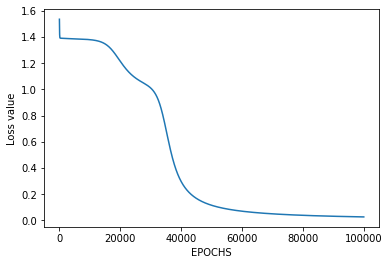

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("EPOCHS")
plt.ylabel("Loss value")
plt.show()


In [ ]:

# Testing
X = np.array([[1, 1, 0, 0], [0, 1, 0, 1]]) # XOR input
cost, _, A2 = forwardPropagation(X, Y, parameters)
prediction = (A2 > 0.5) * 1.0
# print(A2)
print(prediction)

[[1. 0. 0. 1.]
 [1. 0. 0. 1.]]


#DIRECTION OF THE PRICE ON NEXT DAY

##BiLSTM

In [ ]:
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import joblib

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
# import seed
import os
tf.get_logger().setLevel('ERROR')

In [ ]:
"""
method to create lagged features

data - data
to_keep - number of lagged_features
to_remove - number of days to remove

"""
def create_lagged_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    columns, names = list(), list()

    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]

    #put it all together
    final = concat(columns, axis=1)
    final.columns = names

    #drop rows with NaN values
    final.dropna(inplace=True)

    return final

In [ ]:
"""
function to calculate rsi

data - data
period - RSI period

"""
def rsi(data, period: int = 14):

    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [ ]:
#lag granularity - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"

In [ ]:
#read dataset
import pandas as pd
folder = "/content/fyp/datasets/tweets_prices_volumes_sentiment/"+analyser+"/"+dataset_grouped_by+"_datasets/cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_"+str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)


In [ ]:
df.head()

,DateTime,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,dt,Tweet_vol
0,2018-08-30 00:00:00+00:00,7027.99,5.484323,6979.227679,0.043827,0.825543,0.130654,0.230801,2018-08-30 17:27:42.953691904+00:00,557.0
1,2018-08-31 00:00:00+00:00,7187.23,3.694477,7097.021073,0.039833,0.847201,0.112971,0.196773,2018-08-31 12:35:16.275116032+00:00,902.0
2,2018-09-01 00:00:00+00:00,7275.00,2.830380,7233.487967,0.036618,0.846208,0.117174,0.208065,2018-09-01 12:10:04.422492416+00:00,818.0
3,2018-09-02 00:00:00+00:00,7301.01,2.130486,7260.380171,0.047145,0.837654,0.115190,0.163561,2018-09-02 12:19:51.883408128+00:00,860.0
4,2018-09-03 00:00:00+00:00,7357.07,3.392408,7317.186602,0.045408,0.839805,0.114770,0.181093,2018-09-03 12:10:22.157143040+00:00,980.0


In [ ]:
df.shape


(451, 10)

In [ ]:
df = df.groupby('DateTime').mean()

<ipython-input-9-ec340b01f608>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('DateTime').mean()


In [ ]:
df.head()

,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,Tweet_vol
DateTime,,,,,,,,
2018-08-30 00:00:00+00:00,7027.99,5.484323,6979.227679,0.043827,0.825543,0.130654,0.230801,557.0
2018-08-31 00:00:00+00:00,7187.23,3.694477,7097.021073,0.039833,0.847201,0.112971,0.196773,902.0
2018-09-01 00:00:00+00:00,7275.00,2.830380,7233.487967,0.036618,0.846208,0.117174,0.208065,818.0
2018-09-02 00:00:00+00:00,7301.01,2.130486,7260.380171,0.047145,0.837654,0.115190,0.163561,860.0
2018-09-03 00:00:00+00:00,7357.07,3.392408,7317.186602,0.045408,0.839805,0.114770,0.181093,980.0


In [ ]:
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()

if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()

if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

In [ ]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity','Tweet_vol','Volume_(BTC)'] if analyser == "Textblob" else ['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")

if(add_longMAvg):
    features.append("long_mavg")

if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]



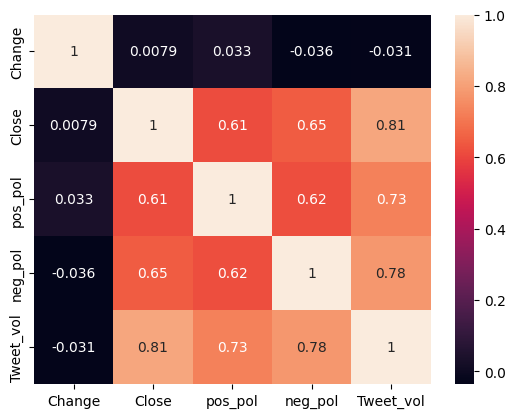

In [ ]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [ ]:


#number of previous records to consider for every example
n_lag = 7
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features



In [ ]:


#add lagged data to records
data_with_lagged = create_lagged_features(df_copy, n_lag, 1)
data_with_lagged = data_with_lagged.reset_index()
data_with_lagged = data_with_lagged.drop(['DateTime'], axis=1)



In [ ]:
np.random.seed(1)
#shuffle times
shuffle_times = 5;
for j in range(0, shuffle_times+1):
    data_with_lagged = shuffle(data_with_lagged)


In [ ]:
#divide df into train and test
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)

train = data_with_lagged.iloc[:train_size]
test = data_with_lagged.iloc[train_size:]

In [ ]:


#prepare labels
train_y = train["var1(t)"].values
test_y = test["var1(t)"].values

train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)



In [ ]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)
joblib.dump(xscaler, 'content/models/bilstm_trend/saved/scaler.pkl')

FileNotFoundError: ignored

In [ ]:


#prepare data
train_labels = train_y
test_labels = test_y



In [ ]:


#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]



In [ ]:


#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]



In [ ]:


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))



In [ ]:


#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 2)



In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 64
epochs = 10000
dropout = 0.25
batch_size = 80
activ_func = "linear"

model.add(Bidirectional(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(neurons, return_sequences=False, activation=activ_func)))
model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =50)

# fit network
history = model.fit(train_X, train_y, epochs=10000, batch_size=batch_size, verbose=2, shuffle=True,validation_split=0.2, callbacks=[callback])


Epoch 1/10000
4/4 - 7s - loss: 0.6975 - accuracy: 0.4983 - val_loss: 0.6852 - val_accuracy: 0.5526 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6885 - accuracy: 0.5282 - val_loss: 0.6836 - val_accuracy: 0.5526 - 156ms/epoch - 39ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6939 - accuracy: 0.5249 - val_loss: 0.6830 - val_accuracy: 0.5526 - 160ms/epoch - 40ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6873 - accuracy: 0.5349 - val_loss: 0.6821 - val_accuracy: 0.5526 - 144ms/epoch - 36ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6873 - accuracy: 0.5415 - val_loss: 0.6829 - val_accuracy: 0.5658 - 153ms/epoch - 38ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6900 - accuracy: 0.4950 - val_loss: 0.6805 - val_accuracy: 0.6316 - 148ms/epoch - 37ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.6881 - accuracy: 0.5316 - val_loss: 0.6795 - val_accuracy: 0.5526 - 168ms/epoch - 42ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.6858 - accuracy: 0.5415 - val_loss: 0.6808 - val_accuracy: 0.5526 - 161ms/epoch - 40ms/step
Epoch

In [ ]:
#save model
model.save("saved/ckpt")

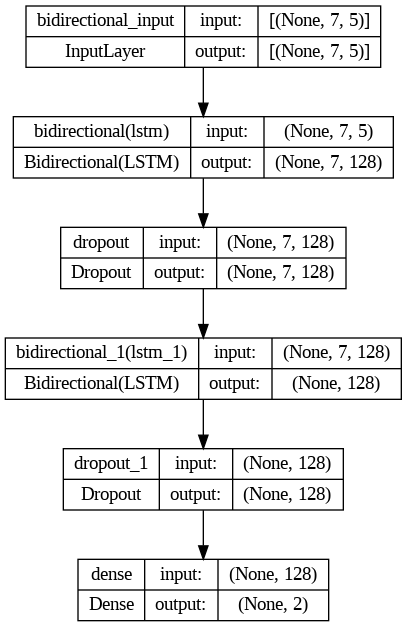

In [ ]:
#save model
model_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)


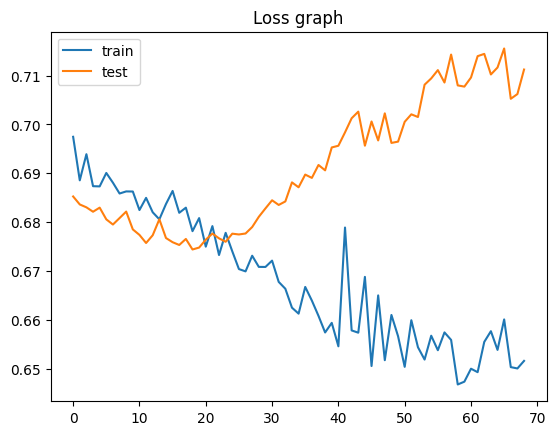

In [ ]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

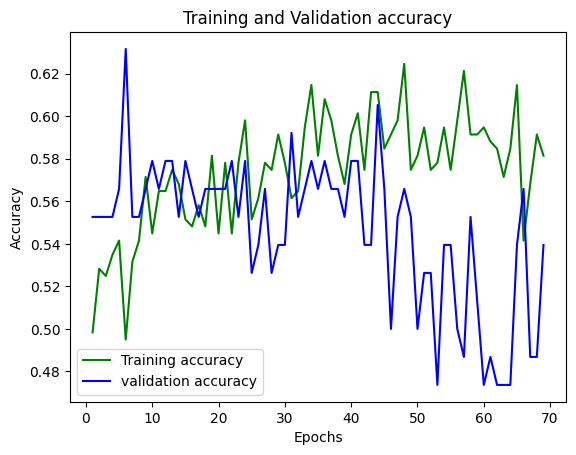

In [ ]:
#plot training and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,len(loss_val) + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

3/3 [==============================] - 1s 6ms/step


In [ ]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [ ]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))


Accuracy =  0.6865671641791045


In [ ]:
sklearn.metrics.classification_report(test_y, pred, zero_division=0,output_dict=True)

{'0': {'precision': 0.8076923076923077,
  'recall': 0.5675675675675675,
  'f1-score': 0.6666666666666666,
  'support': 37},
 '1': {'precision': 0.6097560975609756,
  'recall': 0.8333333333333334,
  'f1-score': 0.7042253521126761,
  'support': 30},
 'accuracy': 0.6865671641791045,
 'macro avg': {'precision': 0.7087242026266416,
  'recall': 0.7004504504504505,
  'f1-score': 0.6854460093896714,
  'support': 67},
 'weighted avg': {'precision': 0.719064153902159,
  'recall': 0.6865671641791045,
  'f1-score': 0.6834839885081634,
  'support': 67}}

##LSTM

##CNN

In [ ]:
!git clone "https://github.com/manas1410/Gene.git"

In [ ]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf
import datetime
import time

In [ ]:
def get_data(symbol, interval, start, end):
    data = yf.download(tickers=symbol, start=start, end=end, interval=interval)
    return data

In [ ]:
symbol = "BTC-USD"
interval = "1d"
start = "2016-01-01"
end = "2021-05-05"

data = get_data(symbol, interval, start, end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


In [ ]:
data.shape

(1951, 6)

In [ ]:
symbol = "BTC-USD"
interval = "1d"
start = "2016-01-01"
end = "2023-04-05"

data = get_data(symbol, interval, start, end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.shape

(2651, 6)

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-31,28032.261719,28639.896484,27583.714844,28478.484375,28478.484375,19001327598
2023-04-01,28473.332031,28802.457031,28297.171875,28411.035156,28411.035156,10876469901
2023-04-02,28462.845703,28518.958984,27884.087891,28199.308594,28199.308594,12284641999
2023-04-03,28183.080078,28475.623047,27276.720703,27790.220703,27790.220703,19556501327
2023-04-04,27795.273438,28433.742188,27681.304688,28168.089844,28168.089844,15284538859


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download alaix14/bitcoin-tweets-20160101-to-20190329

100% 1.58G/1.58G [00:18<00:00, 96.9MB/s]
100% 1.58G/1.58G [00:18<00:00, 90.2MB/s]


In [ ]:
!unzip bitcoin-tweets-20160101-to-20190329.zip

Archive:  bitcoin-tweets-20160101-to-20190329.zip
  inflating: tweets.csv              


In [ ]:
import pandas as pd
df = pd.read_csv('tweets.csv',encoding='latin-1',chunksize = 10000,lineterminator='\n',nrows=200000)

In [ ]:
df

In [ ]:
df.get_chunk(3)

,ï»¿id;user;fullname;url;timestamp;replies;likes;retweets;text\r
0,1132977055300300800;KamdemAbdiel;Abdiel kamdem...
1,1132977073402736640;bitcointe;Bitcointe;;2019-...
2,1132977023893139456;3eyedbran;Bran - 3 Eyed Ra...


In [ ]:
df